# JIRA Reporting Notebook

In [1]:
import arrow
import matplotlib.pyplot as plt
import netrc
import pandas as pd
import pickle

from jira import JIRA
from os.path import exists
from IPython.display import FileLink

from buckley import CustomField, retrieve_issues, Issue

In [2]:
# Global Configuration - shouldn't need to change this
JIRA_DOMAIN = "gremlininc.atlassian.net"
CUSTOM_FIELDS = [
    CustomField(10081, "Work Category"),
    CustomField(10079, "Team Assigned"),
    CustomField(10025, "Story Points"),
]
Issue.CUSTOM_FIELDS = CUSTOM_FIELDS  # Gross.

## Authentication

See README.md in this folder for how to setup authentication

In [3]:
auth_file = netrc.netrc()
authTokens = auth_file.authenticators(JIRA_DOMAIN)

user_email = authTokens[0]
api_token = authTokens[2]

jira_url = f"https://{JIRA_DOMAIN}/"

jira = JIRA(jira_url, basic_auth=(user_email, api_token))

projects = jira.projects()  # List Projects to Test Authentication

## Retrieve Issue Data from Jira API

Jira cloud limits issue searches to 100 results. We paginate over week long periods to collate all the issues from our desired
timeline. See buckley.py for the deets.

We also cache data so that it only pulls once a day. This could be made much less stupid.

In [4]:
cache_key = arrow.utcnow().format("YYYY-MM-DD")
cache_file = f"cache/results_{cache_key}.pickle"

if exists(cache_file):
    print(f"Reading cached results from {cache_file}")
    with open(cache_file, 'rb') as f:
        result_list = pickle.load(f)
else:
    print("Retrieving results from JIRA.")
    result_list = retrieve_issues(jira)
    print(f"Writing results to {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump(result_list, f, pickle.HIGHEST_PROTOCOL)

Reading cached results from cache/results_2022-05-07.pickle


## Convert the gross Jira API result objects into something slightly more reasonable to work with

In [5]:
issues = []

for r in result_list:
    issues.append(Issue(r))        

## Create a pandas dataframe with the issue data as well as calculated fields for reporting

In [6]:
def calculate_lifecycle(issues):
    issue_props = [
        "project",
        "key",
        "summary",
        "story_points",
        "team_assigned",
        "issuetype",
        "work_category",
        "assignee",
        "status",
        "created_date",
        "created_ts",
        "resolution_date",
        "resolution_ts",
    ]

    data = {}
    
    for f in issue_props:
        data[f] = [getattr(x, f) for x in issues]

    df = pd.DataFrame(data)
    df["resolution_year_month"] = df["resolution_date"].astype('datetime64').dt.strftime("%Y-%m")
    df["resolution_month"] = df["resolution_date"].astype('datetime64').dt.month
    df["resolution_year"] = df["resolution_date"].astype('datetime64').dt.year
    df["resolution_qtr"] = df["resolution_date"].astype('datetime64').dt.quarter
    df["resolution_year_qtr"] = df["resolution_year"].map(str) + "Q" + df["resolution_qtr"].map(str)
        
    return df 
    
df = calculate_lifecycle(issues)

## Generate Reports

We generate 2 reports per month:

* Work Category Breakdown by Issue Count
* Issue Type Breakdown by Issue Count

Each report also includes a link to the source data for that specific report for diving deeper.

Similar plots for breakdown by story points are left as an exercise for the reader. 😅

Also side by side formatting would be super nice...

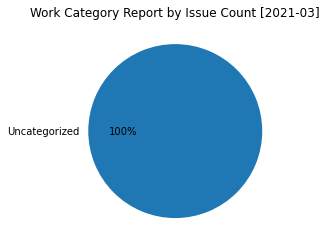

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-03].csv

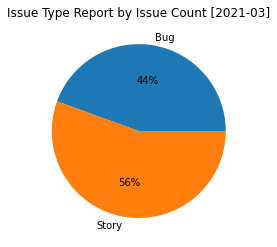

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-03].csv

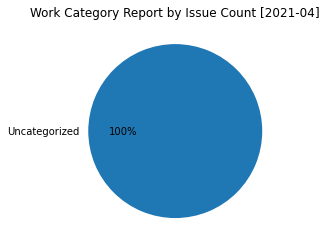

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-04].csv

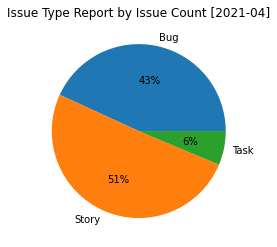

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-04].csv

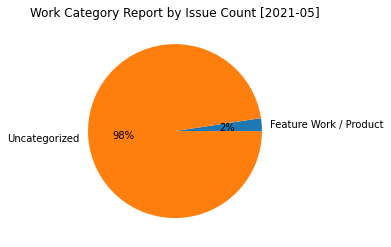

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-05].csv

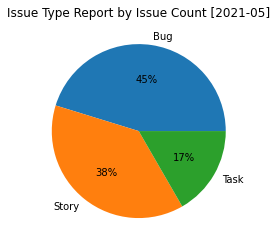

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-05].csv

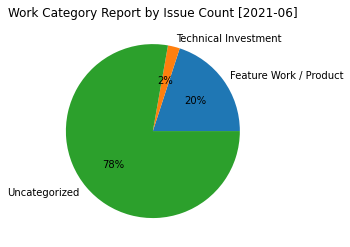

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-06].csv

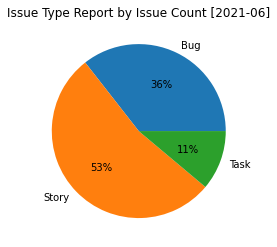

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-06].csv

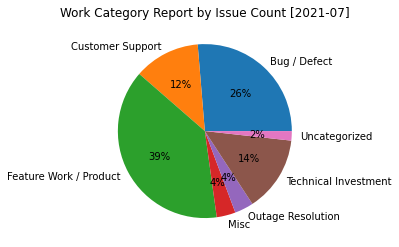

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-07].csv

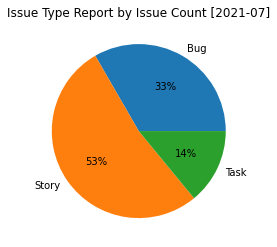

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-07].csv

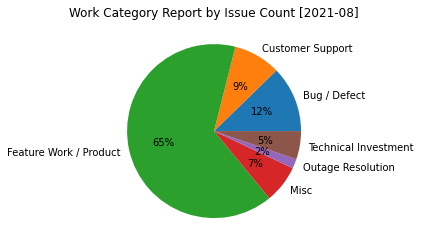

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-08].csv

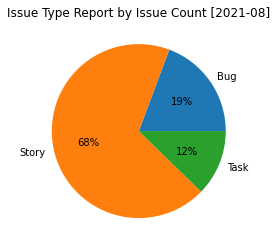

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-08].csv

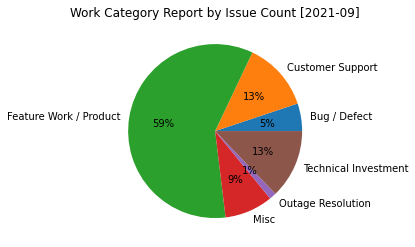

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-09].csv

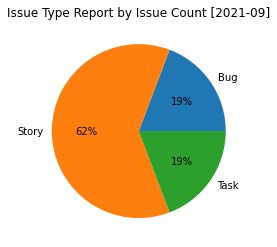

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-09].csv

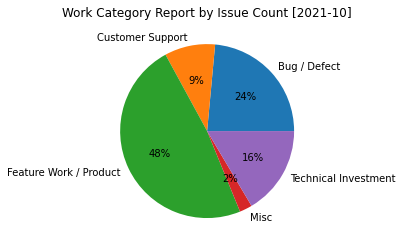

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-10].csv

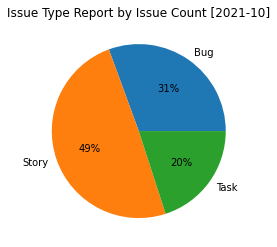

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-10].csv

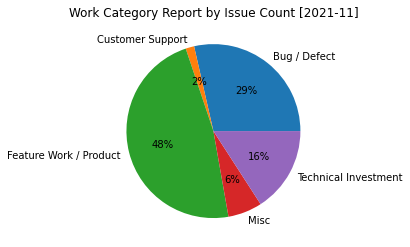

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-11].csv

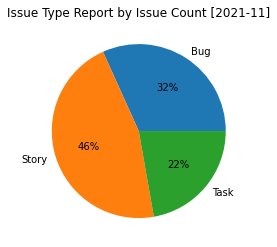

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-11].csv

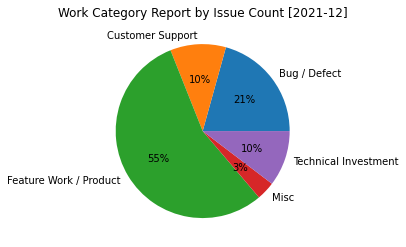

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2021-12].csv

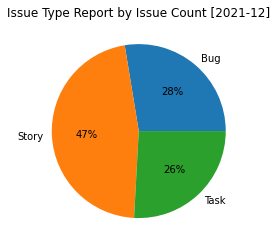

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2021-12].csv

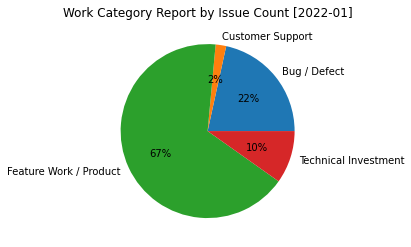

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2022-01].csv

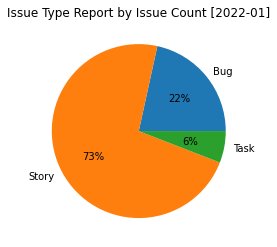

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2022-01].csv

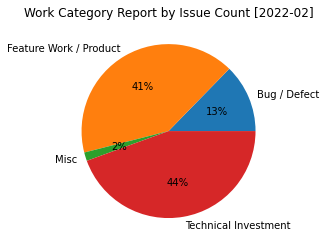

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2022-02].csv

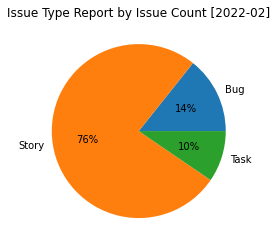

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2022-02].csv

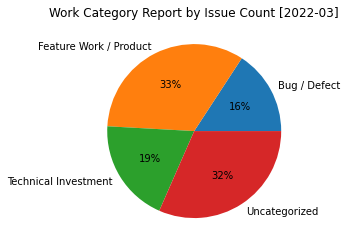

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2022-03].csv

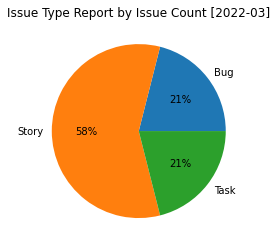

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2022-03].csv

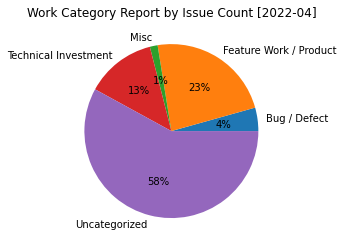

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2022-04].csv

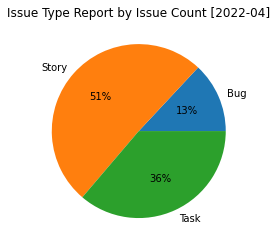

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2022-04].csv

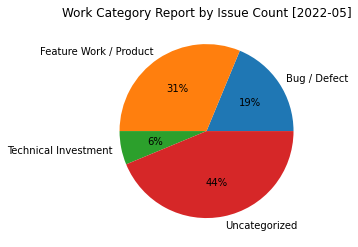

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Work Category Report by Issue Count [2022-05].csv

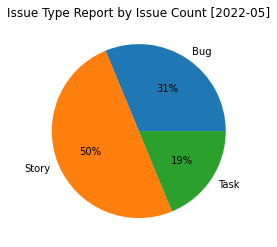

Source Data: 


/Users/jamesthigpen/Development/jira/metrics/output/pie_chart_Issue Type Report by Issue Count [2022-05].csv

In [20]:
def plot_breakdown_report(df, title, groupby_field):
    df_tmp = df[~df["issuetype"].isin(["Sub-task", "Epic"])]
    
    plot_options = {
        "title": title,
        "legend": None,
        "autopct": "%1.0f%%",
        "ylabel": '',
    }
    
    df_tmp.groupby([groupby_field]).nunique().plot.pie(y="key", **plot_options)
    plt.show()

    filename = f"output/pie_chart_{title}.csv"
    df_tmp.to_csv(filename)
    print("Source Data: ")
    display(FileLink(filename))
    print("\n\n")

def plot_work_category_report(df, subtitle):
    plot_breakdown_report(df, f"Work Category Report by Issue Count [{subtitle}]", "work_category")
    
def plot_issuetype_report(df, subtitle):
    plot_breakdown_report(df, f"Issue Type Report by Issue Count [{subtitle}]", "issuetype")


for m in sorted(df["resolution_year_month"].unique()):
    plot_work_category_report(df[df["resolution_year_month"] == m], m)
    plot_issuetype_report(df[df["resolution_year_month"] == m], m)